In [1]:
## import libraries
import sys
import glob
import re

import geopandas as gpd
import cartopy
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import cmocean.cm as cmo
from matplotlib.gridspec import GridSpec

# cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from plotter import draw_basemap, plot_terrain
from utils import roundPartial, select_months_ds

pd.options.display.float_format = "{:,.2f}".format # makes it so pandas tables display only first two decimals

ERROR 1: PROJ: proj_create_from_database: Open of /home/dnash/miniconda3/envs/eaton-scripps/share/proj failed


In [2]:
path_to_data = '/data/projects/Comet/cwp140/' 
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
## Load Basin watershed file
fp = path_to_data + 'downloads/UpperCO/Upper_Colorado_River_Basin_Boundary/Upper_Colorado_River_Basin_Boundary.shp'
basin = gpd.read_file(fp, crs="EPSG:4326") # have to manually set the projection
basin

## get list of HUC8s within Upper Colorado River Basin
# test = gpd.clip(polys, basin)
# test.plot()

,EXT_ID,EXT_TYP_ID,NAME,geometry
0,9389,5.00,Upper Colorado Region,"POLYGON ((-106.65587 40.51559, -106.65376 40.5..."


In [4]:
start_mon = 1
end_mon = 12

da = xr.DataArray(data=np.array([0, 0, 0, 0, 0, 0]),
    dims=["ar_scale"],
    coords=dict(ar_scale=(["ar_scale"], np.array([0.0, 1.0, 2.0, 3.0, 4.0, 5.0]))))

## load PRISM watershed precip dataset
fname = path_to_data + 'preprocessed/PRISM/PRISM_HUC8_CO.nc'
PRISM = xr.open_dataset(fname)
## get just Nov - April
PRISM = select_months_ds(PRISM, start_mon, end_mon, 'date')

HUC8_IDs = PRISM.HUC8.values ## get list of HUC8 IDs

frac_lst = []
ARscale_lst = []
frac_days_lst = []

## loop through all HUC8s
for i, HUC8_ID in enumerate(HUC8_IDs):
    # print(i, HUC8_ID)
    
    tmp = PRISM.sel(HUC8=str(HUC8_ID))
    tmp = tmp.where(tmp.extreme == 1, drop=True)

    ## load final trajectory dataset
    fname = '/home/dnash/comet_data/preprocessed/ERA5_trajectories/latest/PRISM_HUC8_{0}.nc'.format(HUC8_ID)
    traj = xr.open_dataset(fname)
    traj = select_months_ds(traj, start_mon, end_mon, 'start_date')
        
    ## total extreme precip
    total_prec = tmp.prec.sum('date').values
    ct_prec = tmp.prec.count('date').values
    try: 
        ## get all the dates from the trajectory dataset where AR Scale > 0
        ar_days = traj.where(traj.coastal_IVT >= 250., drop=True).start_date.values
        # ar_days = traj.where(traj.ar_scale > 0., drop=True).start_date.values
        # ar_days = traj.where(traj.ar > 0., drop=True).start_date.values
        ## select those dates from precip dataset
        tmp2 = tmp.sel(date=ar_days)
        ## calculate fraction of extreme precipitation related to ARs for each watershed
        ar_prec = tmp2.prec.sum('date').values
        frac = (ar_prec/total_prec)*100
        frac_days = (len(ar_days)/ct_prec)*100
        
        # get the number of times AR scale for each trajectory
        ARscale = traj.groupby("ar_scale").count().ar
        
    except ValueError:
        ## no AR days
        frac = 0
        ARscale = da
        frac_days = 0
    
    frac_lst.append(frac)
    ARscale_lst.append(ARscale)
    frac_days_lst.append(frac_days)
    
## now attach to the geopandas dataframe

## load watershed shapefile
## use geopandas to import the shapefile
fp = path_to_data + 'downloads/CO_HUC8/wbdhu8.shp'
polys = gpd.read_file(fp, crs="epsg:4326") # have to manually set the projection
polys['frac'] = frac_lst
polys['frac_days'] = frac_days_lst

In [5]:
HUC8_ID_lst = [14050001, ## upper yampa
               # 14050005, ## upper white
               # 14050002, ## lower yampa
               # 14080104, ## animas (San Juans),
               14030002, ## upper dolores
               # 11020002, ## arkansas - Pueblo Reservoir
               # 10190005 ## St. Vrain (Boulder)
               # 14030005, ## 'Upper Colorado-Kane Springs'
               10190002, ## 'Upper South Platte'
               11020001 ## Arkansas Headwaters
              ]
idx = (polys.HUC8 == str(HUC8_ID_lst[0])) | (polys.HUC8 == str(HUC8_ID_lst[1])) | (polys.HUC8 == str(HUC8_ID_lst[2])) | (polys.HUC8 == str(HUC8_ID_lst[3]))
tmp =  polys[idx]
tmp

,OBJECTID,TNMID,MetaSource,SourceData,SourceOrig,SourceFeat,LoadDate,GNIS_ID,AreaAcres,AreaSqKm,States,HUC8,Name,Shape_Leng,Shape_Area,geometry,frac,frac_days
20,21,{E174065A-2AA4-49D1-B443-F550A60C869D},None,None,None,None,2016-07-27,0,"1,676,731.25","6,785.50",CO,14050001,Upper Yampa,5.10,0.72,"POLYGON ((-106.77828 40.90596, -106.77765 40.9...",10.82,11.49
49,50,{19D18F78-BA7C-4A1E-A1F6-DA996B233880},None,None,None,None,2017-04-17,0,"1,961,578.79","7,938.23",CO,11020001,Arkansas Headwaters,7.02,0.82,"POLYGON ((-106.21421 39.38309, -106.21368 39.3...",3.87,4.20
83,84,{4715E85E-95AB-43D1-B2BE-D913416DC714},None,None,None,None,2012-06-11,0,"1,380,772.61","5,587.79","CO,UT",14030002,Upper Dolores,5.79,0.57,"POLYGON ((-109.06388 38.46306, -109.06337 38.4...",21.58,21.43
87,88,{AAFC1326-6A7C-49C0-BC17-9573AE42BC21},None,None,None,None,2016-10-11,0,"1,183,831.16","4,790.80",CO,10190002,Upper South Platte,4.29,0.50,"POLYGON ((-105.04506 39.76261, -105.04449 39.7...",0.61,0.85


In [6]:
polys['frac'].max()

35.10329733863601

In [7]:
polys['frac_days'].max()

33.84615384615385

In [8]:
# Set up projection
datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = ccrs.PlateCarree() ## the projection you want your map displayed in

# Set tick/grid locations
ext1 = [-110., -101., 36.5, 41.5] # extent of CO
dx = np.arange(ext1[0],ext1[1]+2,2)
dy = np.arange(ext1[2]-.5,ext1[3]+1,1)

# # make a colormap that has land and ocean clearly delineated and of the
# # same length (256 + 256)
# colors_undersea = plt.cm.terrain(np.linspace(0, 0.17, 256))
# colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
# all_colors = np.vstack((colors_undersea, colors_land))
# terrain_map = mcolors.LinearSegmentedColormap.from_list(
#     'terrain_map', all_colors)
# # make the norm:  Note the center is offset so that the land has more
# # dynamic range:
# divnorm = mcolors.TwoSlopeNorm(vmin=-0.25, vcenter=1, vmax=3000)


wc_rgb = (86./255., 105./255., 166./255.) # color for water features
wc_cmyk = (48., 37., 0., 35.)


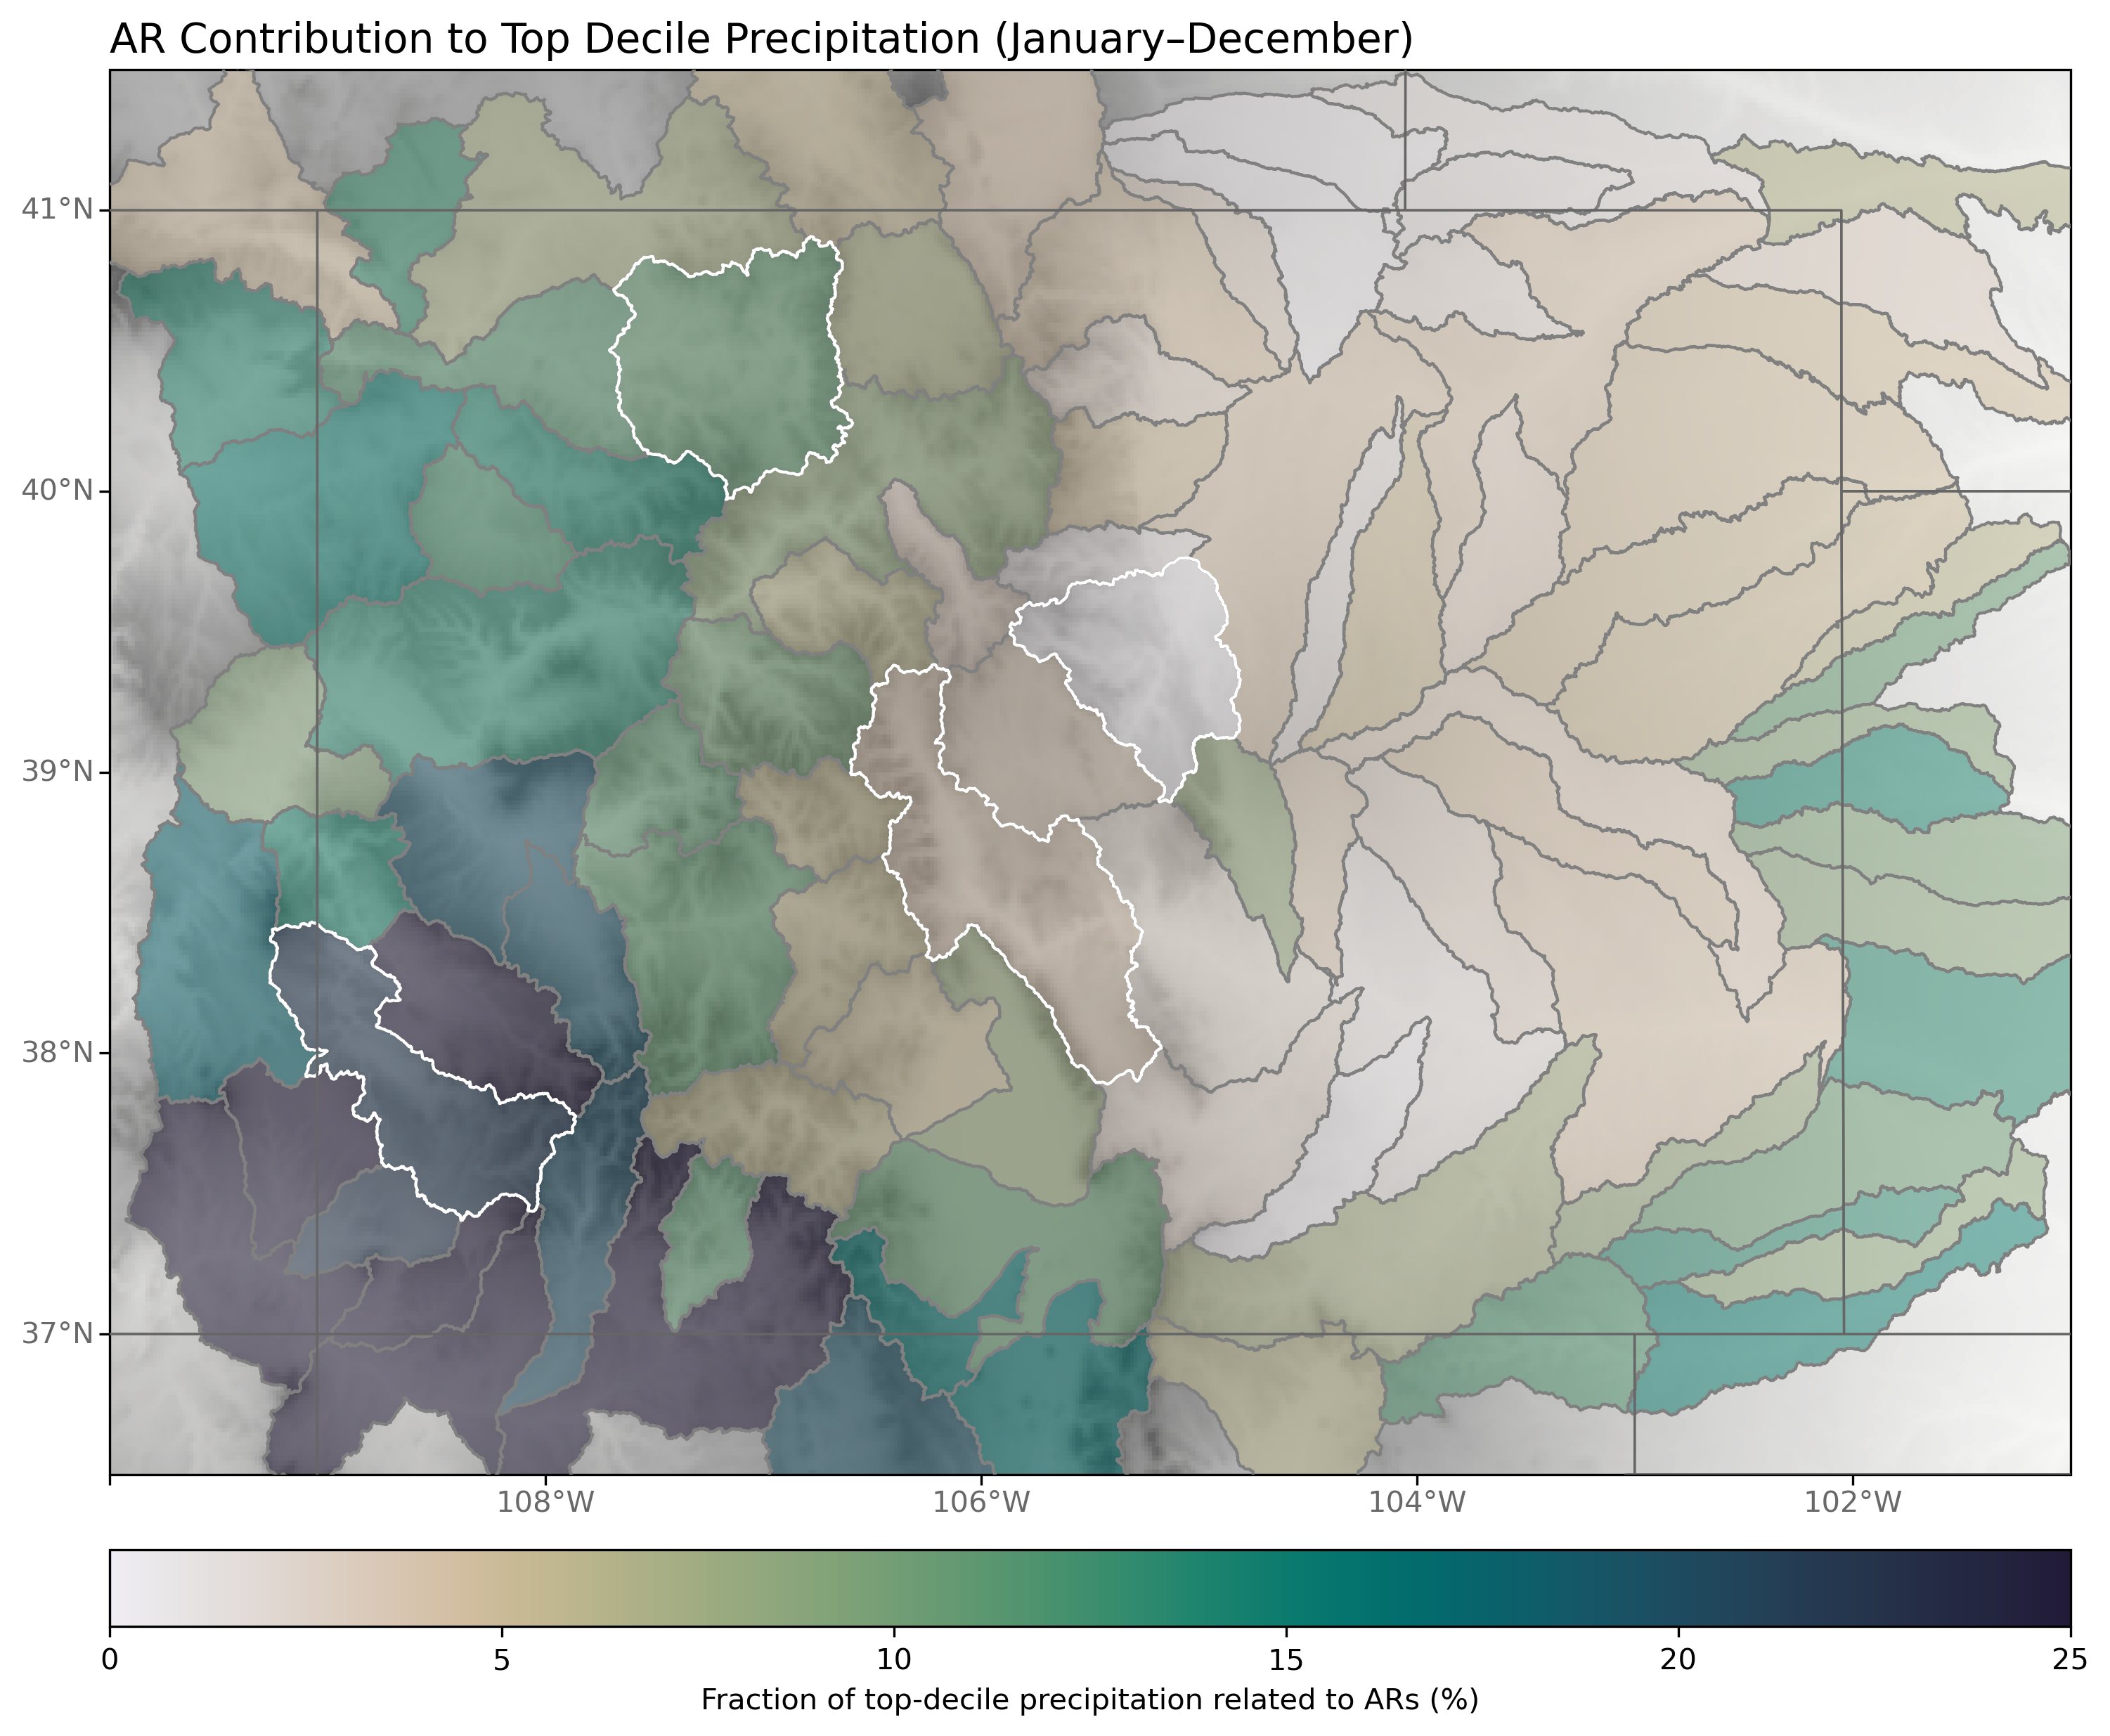

In [9]:
# Create figure
fig = plt.figure(figsize=(12, 10.))
fig.dpi = 300
fname = path_to_figs + 'elevation_7.5_choropleth_map'
fmt = 'png'

nrows = 2
ncols = 1

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 0.05], width_ratios = [1], wspace=0.01, hspace=0.01)
## use gs[rows index, columns index] to access grids

# Add color bar axis
cbax = plt.subplot(gs[1,0]) # colorbar axis

## Add axis for plot
ax = fig.add_subplot(gs[0,0], projection=mapcrs)
ax = draw_basemap(ax, extent=ext1, xticks=dx, yticks=dy,left_lats=True, right_lats=False, mask_ocean=False, coastline=False)

## topo with gray shading
cs = plot_terrain(ax, ext1)

# add choropleth watershed fraction
lgnd_kwds={"label": "Fraction of top-decile precipitation related to ARs (%)", "orientation": "horizontal"}
cf = polys.plot(ax=ax, column="frac", cmap=cmo.rain, vmin=0, vmax=25, alpha=0.5, legend=True, cax=cbax, legend_kwds=lgnd_kwds)
polys.plot(ax=ax, edgecolor='grey', color='None', zorder=98)

ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8, zorder=199)

## add in four focus watersheds
tmp.plot(ax=ax, edgecolor='white', color='None', zorder=99)
# basin.plot(ax=ax, edgecolor='white', color='None', zorder=99)

ax.set_title('AR Contribution to Top Decile Precipitation (January–December)', loc='left', fontsize=14)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()

In [10]:
## concat ARscale dataframes
ds = xr.concat(ARscale_lst, pd.Index(HUC8_IDs, name="HUC8"))
ds.sum('HUC8')

<xarray.DataArray 'ar' (ar_scale: 6)>
array([1425.,  235.,  222.,  264.,  136.,   36.])
Coordinates:
  * ar_scale  (ar_scale) float64 0.0 1.0 2.0 3.0 4.0 5.0

In [11]:
ds

<xarray.DataArray 'ar' (HUC8: 92, ar_scale: 6)>
array([[23.,  8.,  8.,  5.,  2., nan],
       [14.,  8.,  6.,  4., nan, nan],
       [28.,  9.,  3.,  7.,  4.,  1.],
       [34.,  8.,  4.,  3.,  1.,  1.],
       [33.,  3.,  1.,  4.,  2.,  1.],
       [42.,  2.,  8.,  7.,  2.,  1.],
       [ 3., nan,  1., nan,  1., nan],
       [ 1., nan,  1.,  1.,  1., nan],
       [ 7.,  2.,  2.,  2.,  2., nan],
       [ 3.,  1.,  1., nan, nan, nan],
       [ 6., nan, nan,  2., nan, nan],
       [ 5.,  1.,  1.,  2., nan, nan],
       [ 8.,  1., nan,  4.,  2.,  2.],
       [ 9.,  2.,  1., nan,  1., nan],
       [12., nan,  1., nan, nan, nan],
       [ 9.,  1.,  1.,  1.,  2., nan],
       [12., nan,  1.,  3.,  2., nan],
       [12.,  2.,  2.,  2., nan, nan],
       [17.,  4.,  2.,  2.,  1., nan],
       [35.,  6.,  5.,  4.,  1., nan],
...
       [36.,  9., 12.,  9.,  3.,  1.],
       [36.,  5.,  3.,  7.,  3.,  1.],
       [11.,  3., nan,  5.,  1., nan],
       [ 4.,  3.,  2.,  1., nan, nan],
       [ 2., nan, nan,  1.,  1., nan],
       [ 6., nan, nan, nan, nan, nan],
       [ 6., nan,  1., nan,  1., nan],
       [ 7., nan,  1.,  2., nan, nan],
       [13.,  2.,  1.,  4.,  2.,  2.],
       [ 9., nan,  2.,  6.,  1., nan],
       [15.,  7.,  5.,  7., nan, nan],
       [24.,  9.,  2., 14.,  3.,  1.],
       [30.,  6.,  7.,  3.,  6., nan],
       [16.,  3.,  3.,  4.,  4., nan],
       [20.,  1.,  1.,  4.,  2.,  1.],
       [ 6., nan, nan,  2., nan, nan],
       [ 7.,  1.,  1.,  3.,  1., nan],
       [14., nan,  2.,  4.,  1.,  3.],
       [ 9.,  1.,  9.,  1.,  1.,  3.],
       [16.,  1.,  1.,  3.,  3., nan]])
Coordinates:
  * ar_scale  (ar_scale) float64 0.0 1.0 2.0 3.0 4.0 5.0
  * HUC8      (HUC8) object '14080107' '14080105' ... '11030001' '10250013'